# Integrating `Action Graph Service` into `Action` and `ActionObject` Creation

We aim to add an action node whenever an action occurs, or when an action object is created

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig
from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
from syft.service.response import SyftError
from syft.types.syft_object import SyftObjectRegistry

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from pprint import pprint

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft


#### Initializing a node

In [2]:
worker = sy.Worker.named(name="test")
authed_context = AuthedServiceContext(node=worker, 
                                      credentials=worker.signing_key.verify_key)

# node = sy.orchestra.launch(name="test-domain-1", port=8080, dev_mode=True, reset=True)
# domain_client = node.login(email="info@openmined.org", password="changethis")

In [3]:
root_client = worker.root_client
guest_client = worker.guest_client
ds = root_client.register(name="data scientist", 
                          email="ds.openmined.org",
                          password="abc")
assert root_client.credentials != guest_client.credentials

#### Get the node's `action_service` and `action_graph_service`

In [4]:
action_service = worker.get_service("actionservice")
action_graph_service = worker.get_service("actiongraphservice")
print(action_service.store)
print(action_graph_service.store)

In [5]:
assert isinstance(action_graph_service, ActionGraphService)
assert isinstance(action_graph_service.store, InMemoryActionGraphStore)

#### There are 2 places where we add a new `action_object`:
    - when we upload a new dataset
    - when someone send a piece of data to us
Note that we can add an `action_node` in `action_service.set`, but this may create duplications

#### First scenario: Create and upload a dataset

In [6]:
num_assets = 2

In [7]:
dataset = sy.Dataset(name="Test Dataset")
dataset.set_description("""Test Dataset""")
dataset.add_citation("Person, place or thing")

country = sy.DataSubject(name="Country", aliases=["country_code"])
canada = sy.DataSubject(name="Canada", aliases=["country_code:ca"])
country.add_member(canada)
registry = root_client.data_subject_registry
response = registry.add_data_subject(country)

for i in range(num_assets):
    data = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))
    mock = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))

    ctf = sy.Asset(name=f"test_dataset_{i}")
    ctf.set_description("""all the datas""")
    ctf.set_obj(data)
    ctf.set_shape((10, 4))
    ctf.add_data_subject(canada)
    ctf.set_mock(mock, mock_is_real=False)
    dataset.add_asset(ctf)

In [8]:
root_client.upload_dataset(dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.27it/s]

Uploading: test_dataset_0
Uploading: test_dataset_1


<class 'syft.service.response.SyftSuccess'>: Dataset Added

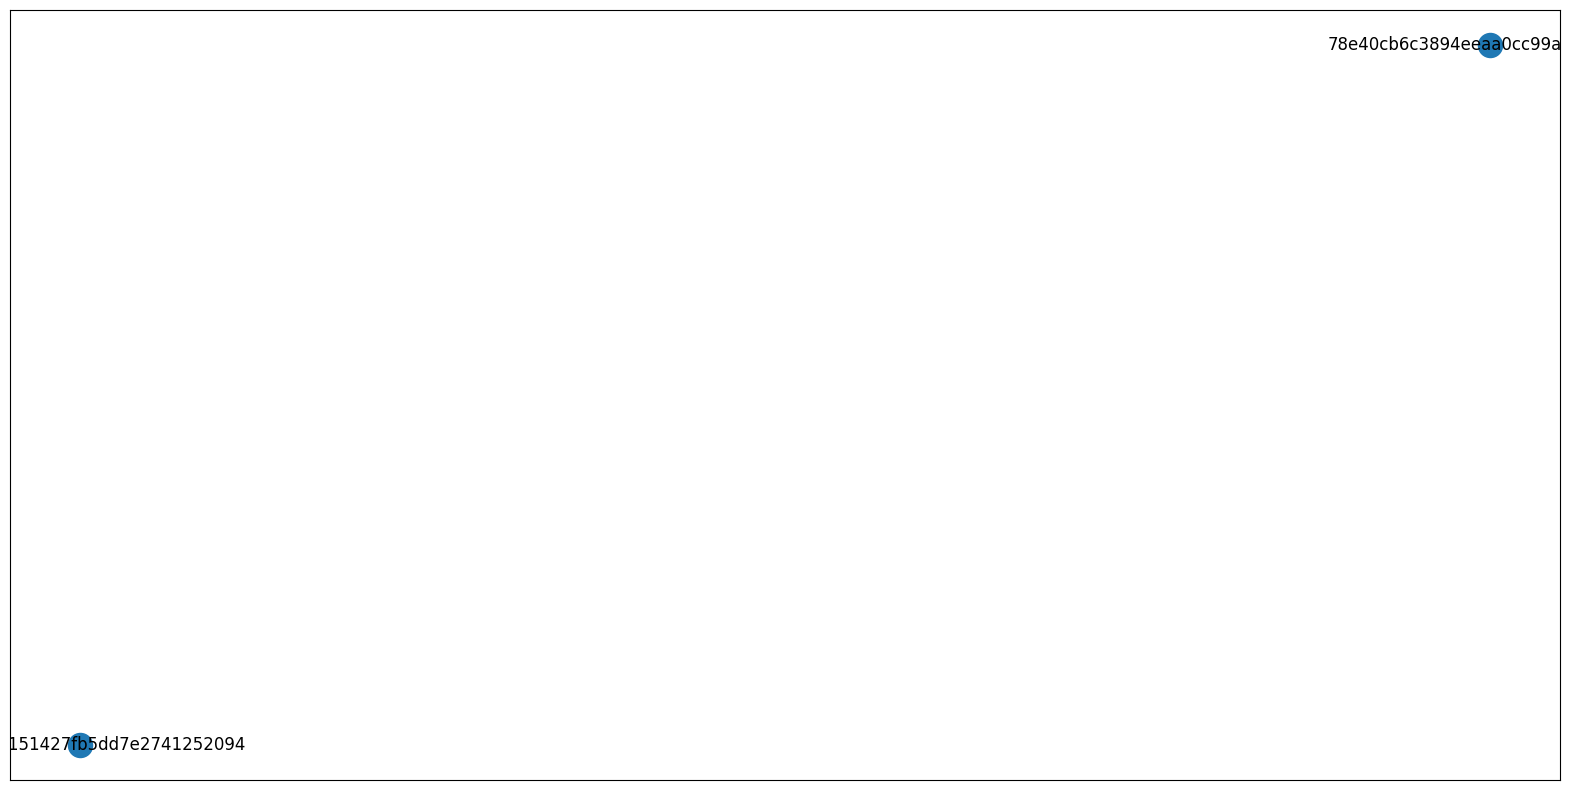

In [9]:
action_graph_service.visualize(context=authed_context)

In [10]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets

#### Scenario 2: when calling `action_obj.send` method

In [11]:
action_obj_a = ActionObject.from_obj([2, 4, 6])

In [12]:
action_obj_a.send(root_client)

Pointer:
[2, 4, 6]

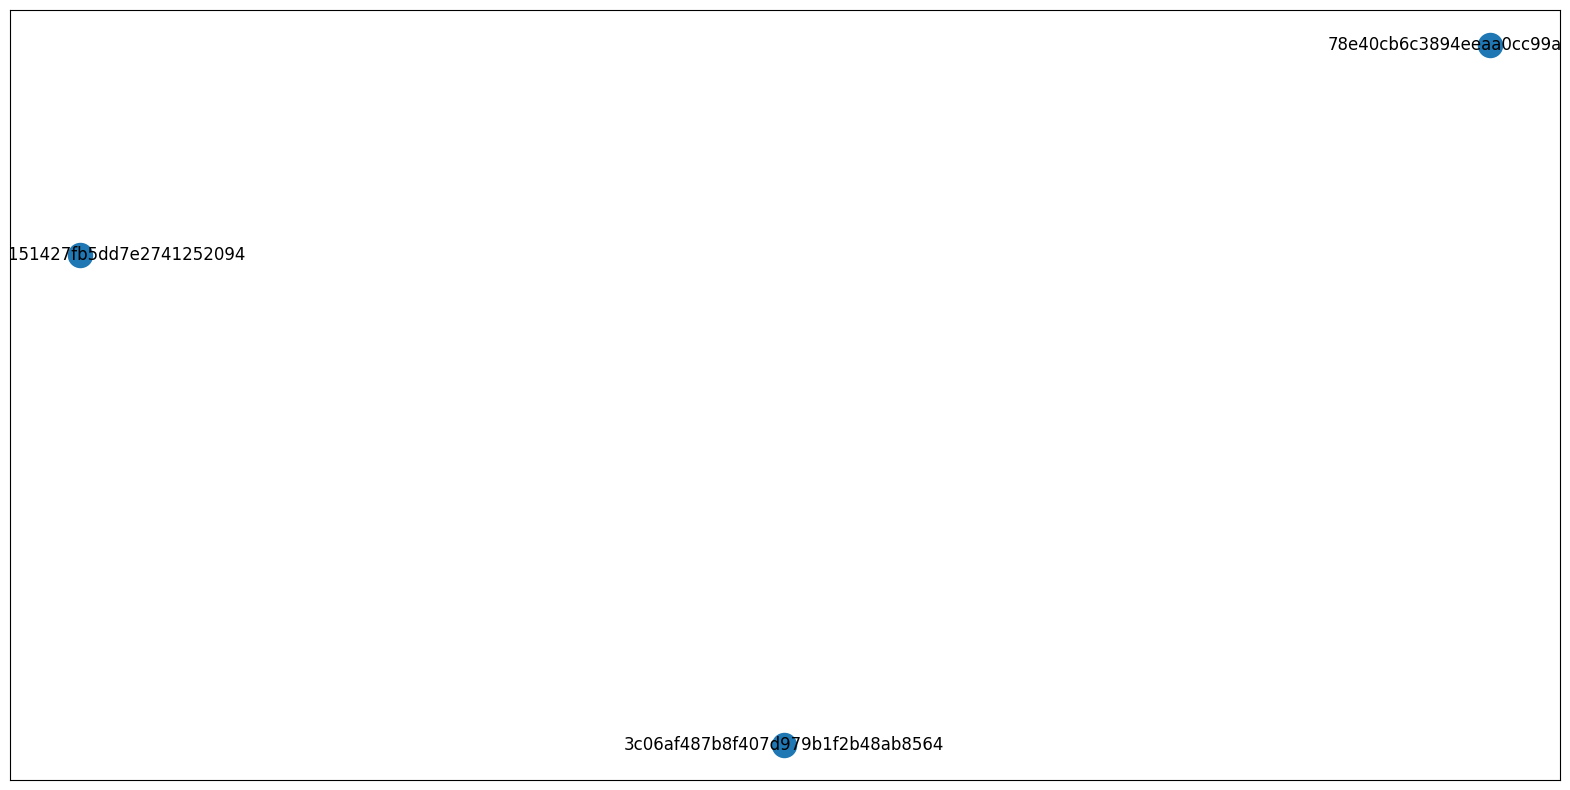

In [13]:
action_graph_service.visualize(context=authed_context)

In [14]:
assert action_graph_service.get(action_obj_a.id, authed_context).id == action_obj_a.id

In [15]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets + 1